# Notebook 5: LLM + RL - RLHF와 미래

## 🎯 학습 목표
- RLHF (Reinforcement Learning from Human Feedback) 이해
- Reward Model 학습과 PPO fine-tuning
- Constitutional AI와 안전한 AI
- LLM을 정책으로 사용하는 방법
- RL과 LLM의 미래 전망

## 1. RLHF의 등장 배경

### LLM의 문제점
- **Alignment Problem**: 인간의 의도와 불일치
- **Harmful outputs**: 유해한 내용 생성
- **Hallucination**: 거짓 정보 생성

### RLHF의 해결책
- **Human Feedback**: 인간의 선호도 학습
- **Reward Model**: 선호도를 보상으로 변환
- **PPO Fine-tuning**: 보상 최대화

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
from dataclasses import dataclass
from collections import defaultdict
import random
from tqdm import tqdm

# 시드 설정
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("\n🤖 LLM + RL 환경 준비 완료!")
print("Key Focus: RLHF를 통한 LLM 정렬")

Using device: cpu

🤖 LLM + RL 환경 준비 완료!
Key Focus: RLHF를 통한 LLM 정렬


## 2. 미니 언어 모델 구현

RLHF를 시연하기 위한 간단한 언어 모델을 구현합니다.

In [2]:
class MiniLM(nn.Module):
    """교육용 미니 언어 모델"""
    
    def __init__(self, vocab_size=1000, embed_dim=128, hidden_dim=256, n_layers=2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_dim, vocab_size)
        
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
    
    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        lstm_out, hidden = self.lstm(embed, hidden)
        logits = self.output(lstm_out)
        return logits, hidden
    
    def generate(self, prompt, max_length=50, temperature=1.0):
        """텍스트 생성"""
        self.eval()
        generated = prompt.copy()
        hidden = None
        
        with torch.no_grad():
            for _ in range(max_length):
                x = torch.tensor([generated[-1]]).unsqueeze(0).to(device)
                logits, hidden = self.forward(x, hidden)
                
                # Temperature sampling
                probs = F.softmax(logits[0, -1] / temperature, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
                
                generated.append(next_token)
                
                # EOS token (가정: 2)
                if next_token == 2:
                    break
        
        return generated

# 간단한 토크나이저
class SimpleTokenizer:
    """간단한 토크나이저"""
    
    def __init__(self):
        # 기본 어휘
        self.vocab = {
            '<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3,
            'good': 4, 'bad': 5, 'helpful': 6, 'harmful': 7,
            'safe': 8, 'unsafe': 9, 'yes': 10, 'no': 11,
            'the': 12, 'is': 13, 'a': 14, 'an': 15,
            'response': 16, 'answer': 17, 'this': 18, 'that': 19
        }
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
    
    def encode(self, text):
        tokens = text.lower().split()
        return [self.vocab.get(t, 3) for t in tokens]  # 3 = <UNK>
    
    def decode(self, tokens):
        return ' '.join([self.inv_vocab.get(t, '<UNK>') for t in tokens])

# 모델과 토크나이저 초기화
model = MiniLM(vocab_size=100).to(device)
tokenizer = SimpleTokenizer()

print("미니 언어 모델 생성 완료")
print(f"모델 파라미터: {sum(p.numel() for p in model.parameters()):,}")

미니 언어 모델 생성 완료
모델 파라미터: 960,100


## 3. RLHF Step 1: 선호도 데이터 수집

인간의 선호도 데이터를 시뮬레이션합니다.

In [3]:
@dataclass
class PreferenceData:
    """선호도 데이터"""
    prompt: str
    response_a: str
    response_b: str
    preferred: str  # 'A' or 'B'

def generate_preference_data(n_samples=100):
    """선호도 데이터 생성 (시뮬레이션)"""
    
    data = []
    
    # 안전성 관련 예제
    safety_prompts = [
        "Is this safe?",
        "Should I do this?",
        "Can you help?"
    ]
    
    for _ in range(n_samples):
        prompt = random.choice(safety_prompts)
        
        # 두 가지 응답 생성
        safe_response = random.choice([
            "This is safe and helpful",
            "Yes this is good",
            "The answer is helpful"
        ])
        
        unsafe_response = random.choice([
            "This is harmful and bad",
            "No this is unsafe",
            "The response is harmful"
        ])
        
        # 랜덤하게 A/B 할당
        if random.random() < 0.5:
            response_a = safe_response
            response_b = unsafe_response
            preferred = 'A'  # 안전한 응답 선호
        else:
            response_a = unsafe_response
            response_b = safe_response
            preferred = 'B'  # 안전한 응답 선호
        
        data.append(PreferenceData(
            prompt=prompt,
            response_a=response_a,
            response_b=response_b,
            preferred=preferred
        ))
    
    return data

# 선호도 데이터 생성
preference_data = generate_preference_data(200)

print("선호도 데이터 예시:")
for i in range(3):
    sample = preference_data[i]
    print(f"\n샘플 {i+1}:")
    print(f"  Prompt: {sample.prompt}")
    print(f"  Response A: {sample.response_a}")
    print(f"  Response B: {sample.response_b}")
    print(f"  Preferred: {sample.preferred}")

print(f"\n총 {len(preference_data)}개 선호도 데이터 생성 완료")

선호도 데이터 예시:

샘플 1:
  Prompt: Can you help?
  Response A: This is harmful and bad
  Response B: This is safe and helpful
  Preferred: B

샘플 2:
  Prompt: Is this safe?
  Response A: This is harmful and bad
  Response B: This is safe and helpful
  Preferred: B

샘플 3:
  Prompt: Can you help?
  Response A: The answer is helpful
  Response B: The response is harmful
  Preferred: A

총 200개 선호도 데이터 생성 완료


## 4. RLHF Step 2: Reward Model 학습

선호도 데이터로부터 보상 모델을 학습합니다.


보상 모델 학습 시작...
Epoch 2/10, Loss: 0.6930
Epoch 4/10, Loss: 0.6822
Epoch 6/10, Loss: 0.1303
Epoch 8/10, Loss: 0.0024
Epoch 10/10, Loss: 0.0005


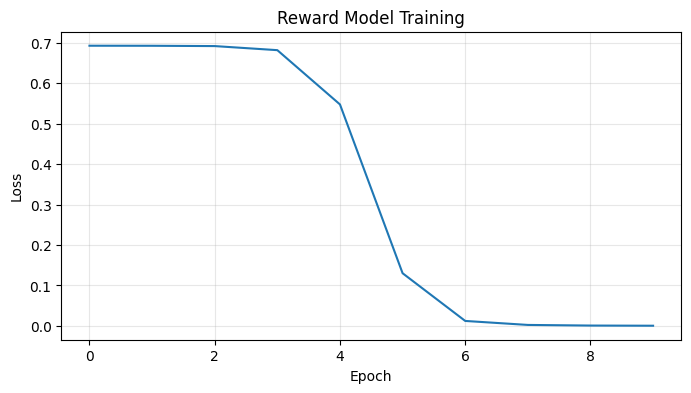

In [4]:
class RewardModel(nn.Module):
    """보상 모델: 응답의 품질을 평가"""
    
    def __init__(self, input_dim=128, hidden_dim=64):
        super().__init__()
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # 스칼라 보상
    
    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        _, (hidden, _) = self.encoder(x)
        hidden = hidden[-1]  # 마지막 hidden state
        
        x = F.relu(self.fc1(hidden))
        reward = self.fc2(x)
        return reward.squeeze()

class PreferenceDataset(Dataset):
    """선호도 데이터셋"""
    
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # 텍스트를 임베딩으로 변환 (간단한 원-핫 인코딩)
        prompt_tokens = self.tokenizer.encode(sample.prompt)
        response_a_tokens = self.tokenizer.encode(sample.response_a)
        response_b_tokens = self.tokenizer.encode(sample.response_b)
        
        # 패딩
        max_len = 20
        prompt_tokens = prompt_tokens[:max_len] + [0] * (max_len - len(prompt_tokens))
        response_a_tokens = response_a_tokens[:max_len] + [0] * (max_len - len(response_a_tokens))
        response_b_tokens = response_b_tokens[:max_len] + [0] * (max_len - len(response_b_tokens))
        
        return {
            'prompt': torch.tensor(prompt_tokens),
            'response_a': torch.tensor(response_a_tokens),
            'response_b': torch.tensor(response_b_tokens),
            'preferred': 1.0 if sample.preferred == 'A' else 0.0
        }

def train_reward_model(reward_model, dataset, n_epochs=10):
    """보상 모델 학습"""
    
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    optimizer = optim.Adam(reward_model.parameters(), lr=1e-3)
    losses = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        
        for batch in dataloader:
            # 간단한 원-핫 인코딩
            response_a = F.one_hot(batch['response_a'], num_classes=100).float()
            response_b = F.one_hot(batch['response_b'], num_classes=100).float()
            
            # 보상 예측
            reward_a = reward_model(response_a)
            reward_b = reward_model(response_b)
            
            # Bradley-Terry 모델 손실
            # P(A > B) = sigma(r_A - r_B)
            preferred = batch['preferred'].float().to(device)
            
            # A가 선호되면 1, B가 선호되면 0
            logits = reward_a - reward_b
            loss = F.binary_cross_entropy_with_logits(logits, preferred)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    return losses

# 보상 모델 학습
reward_model = RewardModel(input_dim=100).to(device)
dataset = PreferenceDataset(preference_data, tokenizer)

print("\n보상 모델 학습 시작...")
losses = train_reward_model(reward_model, dataset, n_epochs=10)

# 학습 곡선 시각화
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reward Model Training')
plt.grid(True, alpha=0.3)
plt.show()

## 5. RLHF Step 3: PPO Fine-tuning

학습된 보상 모델을 사용하여 언어 모델을 PPO로 fine-tuning합니다.


PPO Fine-tuning 시작...
Iteration 10: Avg Reward = 0.006
Iteration 20: Avg Reward = 0.152
Iteration 30: Avg Reward = 0.017
Iteration 40: Avg Reward = 0.231
Iteration 50: Avg Reward = 0.289


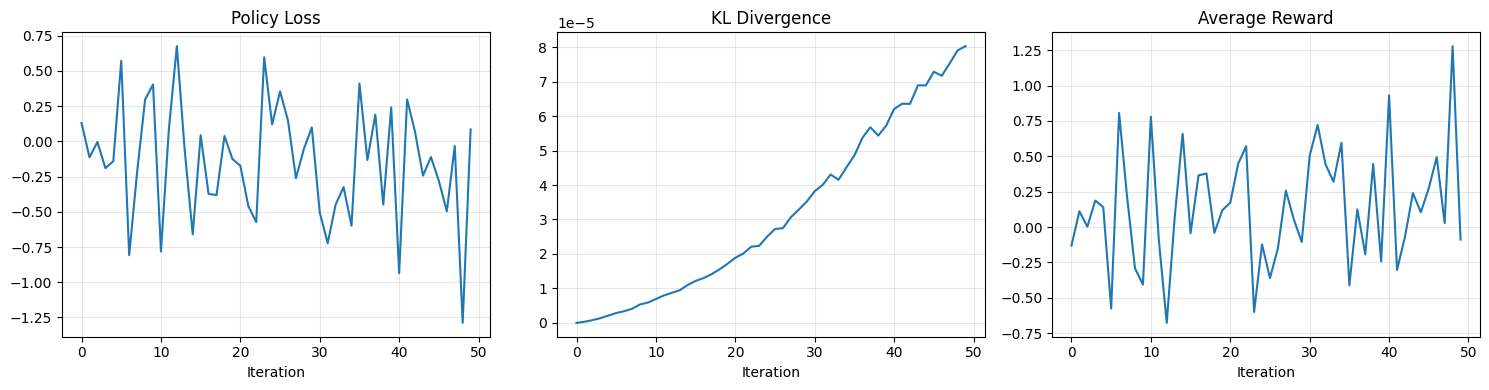

In [5]:
class PPOTrainer:
    """PPO를 사용한 LLM Fine-tuning"""
    
    def __init__(self, policy_model, reward_model, lr=1e-4, gamma=0.99, eps_clip=0.2):
        self.policy = policy_model
        self.reward_model = reward_model
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        
        # 기준 정책 (초기 정책 복사)
        self.ref_policy = MiniLM(vocab_size=100).to(device)
        self.ref_policy.load_state_dict(policy_model.state_dict())
        
        self.kl_coef = 0.1  # KL 패널티 계수
    
    def compute_rewards(self, responses):
        """보상 계산"""
        with torch.no_grad():
            # 원-핫 인코딩
            response_encoded = F.one_hot(responses, num_classes=100).float()
            rewards = self.reward_model(response_encoded)
        return rewards
    
    def compute_kl_penalty(self, logits, ref_logits):
        """KL divergence 패널티"""
        log_probs = F.log_softmax(logits, dim=-1)
        ref_probs = F.softmax(ref_logits, dim=-1)
        
        kl = (ref_probs * (ref_probs.log() - log_probs)).sum(-1)
        return kl.mean()
    
    def train_step(self, prompts, responses, old_log_probs):
        """PPO 학습 스텝"""
        
        # 현재 정책의 log probability
        logits, _ = self.policy(responses)
        log_probs = F.log_softmax(logits, dim=-1)
        
        # 선택된 행동의 log prob
        batch_size, seq_len = responses.shape
        indices = responses.unsqueeze(-1)
        selected_log_probs = log_probs.gather(-1, indices).squeeze(-1)
        
        # Ratio r(θ)
        ratio = torch.exp(selected_log_probs - old_log_probs)
        
        # 보상 계산
        rewards = self.compute_rewards(responses)
        
        # Advantage (간단한 버전)
        advantages = rewards.unsqueeze(1).expand_as(ratio)
        
        # Clipped objective
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()
        
        # KL 패널티
        with torch.no_grad():
            ref_logits, _ = self.ref_policy(responses)
        kl_loss = self.compute_kl_penalty(logits, ref_logits)
        
        # 총 손실
        total_loss = policy_loss + self.kl_coef * kl_loss
        
        # 역전파
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.optimizer.step()
        
        return {
            'policy_loss': policy_loss.item(),
            'kl_loss': kl_loss.item(),
            'reward': rewards.mean().item()
        }

# PPO 학습 시뮬레이션
def simulate_ppo_training(n_iterations=50):
    """PPO fine-tuning 시뮬레이션"""
    
    trainer = PPOTrainer(model, reward_model)
    
    history = defaultdict(list)
    
    print("\nPPO Fine-tuning 시작...")
    
    for iteration in range(n_iterations):
        # 샘플 프롬프트
        prompts = torch.randint(4, 20, (16, 10)).to(device)  # 배치 프롬프트
        
        # 응답 생성 (간단한 시뮬레이션)
        with torch.no_grad():
            logits, _ = model(prompts)
            responses = torch.multinomial(F.softmax(logits.view(-1, 100), dim=-1), 1)
            responses = responses.view(16, 10)
            
            # Old log probs
            old_log_probs = F.log_softmax(logits, dim=-1)
            old_log_probs = old_log_probs.gather(-1, responses.unsqueeze(-1)).squeeze(-1)
        
        # PPO 학습
        metrics = trainer.train_step(prompts, responses, old_log_probs.detach())
        
        # 기록
        for k, v in metrics.items():
            history[k].append(v)
        
        if (iteration + 1) % 10 == 0:
            avg_reward = np.mean(history['reward'][-10:])
            print(f"Iteration {iteration+1}: Avg Reward = {avg_reward:.3f}")
    
    return history

# PPO 학습 실행
history = simulate_ppo_training(50)

# 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['policy_loss'])
axes[0].set_title('Policy Loss')
axes[0].set_xlabel('Iteration')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['kl_loss'])
axes[1].set_title('KL Divergence')
axes[1].set_xlabel('Iteration')
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['reward'])
axes[2].set_title('Average Reward')
axes[2].set_xlabel('Iteration')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Constitutional AI

Anthropic의 Constitutional AI 접근법을 구현합니다.

In [6]:
class ConstitutionalAI:
    """
    Constitutional AI: 원칙 기반 자기 개선
    """
    
    def __init__(self):
        # AI 헌법 (원칙들)
        self.constitution = [
            "Be helpful and harmless",
            "Avoid generating unsafe content",
            "Be honest and transparent",
            "Respect human values",
            "Promote beneficial outcomes"
        ]
        
        self.critique_prompts = [
            "Is this response helpful?",
            "Could this cause harm?",
            "Is this truthful?",
            "Does this respect the user?"
        ]
    
    def critique(self, response):
        """
        응답을 헌법 원칙에 따라 비평
        """
        critiques = []
        
        # 각 원칙에 대해 평가
        for principle in self.constitution:
            # 간단한 규칙 기반 평가 (실제로는 LLM 사용)
            if "harmful" in response.lower() or "unsafe" in response.lower():
                critiques.append(f"Violates: {principle}")
            elif "helpful" in response.lower() or "safe" in response.lower():
                critiques.append(f"Follows: {principle}")
        
        return critiques
    
    def revise(self, response, critiques):
        """
        비평을 바탕으로 응답 수정
        """
        # 위반 사항이 있으면 수정
        violations = [c for c in critiques if "Violates" in c]
        
        if violations:
            # 간단한 수정 (실제로는 LLM이 수정)
            revised = response.replace("harmful", "helpful")
            revised = revised.replace("unsafe", "safe")
            revised = revised.replace("bad", "good")
            return revised, True
        
        return response, False
    
    def constitutional_training_loop(self, responses):
        """
        헌법적 학습 루프
        """
        improved_responses = []
        
        for response in responses:
            # 1. 초기 응답 생성
            print(f"\n원본 응답: {response}")
            
            # 2. 자기 비평
            critiques = self.critique(response)
            print(f"비평: {critiques[:2]}...")  # 처음 2개만 표시
            
            # 3. 수정
            revised, was_revised = self.revise(response, critiques)
            
            if was_revised:
                print(f"수정됨: {revised}")
            else:
                print("수정 불필요")
            
            improved_responses.append(revised)
        
        return improved_responses

# Constitutional AI 데모
print("🏛️ Constitutional AI 데모")
print("="*50)

const_ai = ConstitutionalAI()

# 테스트 응답들
test_responses = [
    "This is harmful and unsafe content",
    "This is helpful and safe information",
    "This response might be bad for users",
    "Here is a good and beneficial answer"
]

print("\n헌법 원칙:")
for i, principle in enumerate(const_ai.constitution, 1):
    print(f"  {i}. {principle}")

print("\n헌법적 학습 과정:")
improved = const_ai.constitutional_training_loop(test_responses)

print("\n\n개선 결과 요약:")
print(f"개선된 응답 수: {sum(1 for o, i in zip(test_responses, improved) if o != i)}/{len(test_responses)}")

🏛️ Constitutional AI 데모

헌법 원칙:
  1. Be helpful and harmless
  2. Avoid generating unsafe content
  3. Be honest and transparent
  4. Respect human values
  5. Promote beneficial outcomes

헌법적 학습 과정:

원본 응답: This is harmful and unsafe content
비평: ['Violates: Be helpful and harmless', 'Violates: Avoid generating unsafe content']...
수정됨: This is helpful and safe content

원본 응답: This is helpful and safe information
비평: ['Follows: Be helpful and harmless', 'Follows: Avoid generating unsafe content']...
수정 불필요

원본 응답: This response might be bad for users
비평: []...
수정 불필요

원본 응답: Here is a good and beneficial answer
비평: []...
수정 불필요


개선 결과 요약:
개선된 응답 수: 1/4


## 7. LLM as Policy

LLM을 직접 RL 정책으로 사용하는 방법을 탐구합니다.

In [7]:
class LLMPolicy:
    """
    LLM을 정책으로 사용
    """
    
    def __init__(self, model_name="mini-llm"):
        self.model_name = model_name
        self.action_space = ["move_left", "move_right", "move_up", "move_down", "think", "plan"]
        self.memory = []  # 경험 메모리
    
    def get_action(self, state, use_cot=True):
        """
        상태를 입력받아 행동 선택
        """
        if use_cot:
            # Chain-of-Thought 사용
            thought = self._think(state)
            action = self._decide(state, thought)
        else:
            # 직접 행동 선택
            action = self._decide(state, None)
        
        return action
    
    def _think(self, state):
        """
        Chain-of-Thought 추론
        """
        thoughts = []
        
        # 상태 분석
        thoughts.append(f"현재 상태: {state}")
        
        # 목표 확인
        if "goal" in state:
            thoughts.append(f"목표: {state['goal']}에 도달")
        
        # 장애물 확인
        if "obstacles" in state:
            thoughts.append(f"장애물 회피 필요")
        
        # 전략 수립
        if state.get("distance_to_goal", float('inf')) > 5:
            thoughts.append("전략: 먼저 계획 수립")
        else:
            thoughts.append("전략: 직접 이동")
        
        return thoughts
    
    def _decide(self, state, thoughts):
        """
        추론을 바탕으로 행동 결정
        """
        if thoughts and "계획 수립" in str(thoughts):
            return "plan"
        
        # 간단한 규칙 기반 결정 (실제로는 LLM이 결정)
        if state.get("x", 0) < state.get("goal_x", 10):
            return "move_right"
        elif state.get("x", 0) > state.get("goal_x", 0):
            return "move_left"
        elif state.get("y", 0) < state.get("goal_y", 10):
            return "move_up"
        else:
            return "move_down"
    
    def learn_from_feedback(self, state, action, reward, next_state):
        """
        피드백으로부터 학습
        """
        experience = {
            'state': state,
            'action': action,
            'reward': reward,
            'next_state': next_state
        }
        
        self.memory.append(experience)
        
        # In-context learning 시뮬레이션
        if len(self.memory) > 10:
            # 최근 경험에서 패턴 학습
            recent_rewards = [e['reward'] for e in self.memory[-10:]]
            avg_reward = np.mean(recent_rewards)
            
            if avg_reward < 0:
                print(f"📉 성능 저하 감지. 전략 조정 필요")
            elif avg_reward > 0.5:
                print(f"📈 좋은 성능! 현재 전략 유지")

# LLM Policy 테스트
def test_llm_policy():
    """LLM을 정책으로 사용하는 예제"""
    
    print("\n🤖 LLM as Policy 데모")
    print("="*50)
    
    llm_policy = LLMPolicy()
    
    # 간단한 네비게이션 태스크
    states = [
        {'x': 0, 'y': 0, 'goal_x': 5, 'goal_y': 5, 'distance_to_goal': 7},
        {'x': 2, 'y': 2, 'goal_x': 5, 'goal_y': 5, 'distance_to_goal': 4},
        {'x': 4, 'y': 4, 'goal_x': 5, 'goal_y': 5, 'distance_to_goal': 1},
        {'x': 5, 'y': 5, 'goal_x': 5, 'goal_y': 5, 'distance_to_goal': 0}
    ]
    
    print("\nChain-of-Thought 사용:")
    for i, state in enumerate(states):
        print(f"\nStep {i+1}:")
        action = llm_policy.get_action(state, use_cot=True)
        print(f"  상태: ({state['x']}, {state['y']}), 목표: ({state['goal_x']}, {state['goal_y']})")
        print(f"  선택된 행동: {action}")
        
        # 피드백 시뮬레이션
        reward = 1.0 if state['distance_to_goal'] == 0 else -0.1
        next_state = states[min(i+1, len(states)-1)]
        llm_policy.learn_from_feedback(state, action, reward, next_state)
    
    print("\n\nDirect Action (CoT 없이):")
    for i, state in enumerate(states[:2]):
        action = llm_policy.get_action(state, use_cot=False)
        print(f"Step {i+1}: 행동 = {action}")

test_llm_policy()


🤖 LLM as Policy 데모

Chain-of-Thought 사용:

Step 1:
  상태: (0, 0), 목표: (5, 5)
  선택된 행동: plan

Step 2:
  상태: (2, 2), 목표: (5, 5)
  선택된 행동: move_right

Step 3:
  상태: (4, 4), 목표: (5, 5)
  선택된 행동: move_right

Step 4:
  상태: (5, 5), 목표: (5, 5)
  선택된 행동: move_down


Direct Action (CoT 없이):
Step 1: 행동 = move_right
Step 2: 행동 = move_right


## 8. Multi-Agent RL with LLMs

여러 LLM 에이전트가 협력하는 시스템을 구현합니다.

In [ ]:
class MultiAgentSystem:
    """
    멀티 에이전트 시스템: 여러 LLM이 협력
    """
    
    def __init__(self, n_agents=3):
        self.agents = []
        
        # 다양한 역할의 에이전트 생성
        roles = ["Explorer", "Planner", "Executor"]
        
        for i in range(n_agents):
            agent = {
                'id': i,
                'role': roles[i % len(roles)],
                'policy': LLMPolicy(),
                'messages': []
            }
            self.agents.append(agent)
    
    def communicate(self, sender_id, message):
        """
        에이전트 간 통신
        """
        sender = self.agents[sender_id]
        
        # 모든 다른 에이전트에게 메시지 전송
        for agent in self.agents:
            if agent['id'] != sender_id:
                agent['messages'].append({
                    'from': sender['role'],
                    'content': message
                })
    
    def collaborate(self, task):
        """
        협력하여 작업 수행
        """
        print(f"\n🤝 협력 작업: {task}")
        print("="*40)
        
        results = []
        
        for agent in self.agents:
            print(f"\n{agent['role']} (Agent {agent['id']}):")
            
            if agent['role'] == "Explorer":
                # 탐색 역할
                observation = f"환경을 탐색한 결과: 장애물 3개, 목표까지 거리 10"
                print(f"  탐색 결과: {observation}")
                self.communicate(agent['id'], observation)
                results.append(observation)
                
            elif agent['role'] == "Planner":
                # 계획 역할
                # 받은 메시지 확인
                if agent['messages']:
                    latest_msg = agent['messages'][-1]
                    print(f"  받은 정보: {latest_msg['content'][:50]}...")
                
                plan = "계획: 1) 장애물 회피, 2) 최단 경로 이동, 3) 목표 도달"
                print(f"  수립한 계획: {plan}")
                self.communicate(agent['id'], plan)
                results.append(plan)
                
            elif agent['role'] == "Executor":
                # 실행 역할
                if agent['messages']:
                    latest_msg = agent['messages'][-1]
                    print(f"  받은 계획: {latest_msg['content'][:50]}...")
                
                actions = ["move_right", "move_up", "avoid_obstacle", "move_right"]
                print(f"  실행 행동: {actions[:3]}...")
                results.append(actions)
        
        return results
    
    def emergent_behavior(self):
        """
        창발적 행동 시뮬레이션
        """
        print("\n🌟 창발적 행동 관찰")
        print("="*40)
        
        # 에이전트들이 자율적으로 역할 조정
        for i in range(3):
            print(f"\n라운드 {i+1}:")
            
            # 각 에이전트가 현재 상황 평가
            for agent in self.agents:
                # 메시지 수 기반으로 활성도 결정
                activity = len(agent['messages'])
                
                if activity < 2:
                    print(f"  {agent['role']}: 더 적극적으로 참여")
                    self.communicate(agent['id'], f"{agent['role']} 활성화")
                else:
                    print(f"  {agent['role']}: 다른 에이전트 지원")
            
            # 메시지 일부 클리어 (메모리 관리)
            for agent in self.agents:
                if len(agent['messages']) > 5:
                    agent['messages'] = agent['messages'][-3:]

# 멀티 에이전트 시스템 테스트
mas = MultiAgentSystem(n_agents=3)

# 협력 작업
results = mas.collaborate("복잡한 미로 탈출")

# 창발적 행동
mas.emergent_behavior()

print("\n\n💡 멀티 에이전트 시스템의 장점:")
print("  • 역할 분담으로 효율성 증가")
print("  • 병렬 처리 가능")
print("  • 창발적 문제 해결")
print("  • robust한 시스템")

## 9. RL과 LLM의 미래

향후 발전 방향과 가능성을 탐구합니다.


🚀 RL과 LLM의 미래

1. 자율 에이전트
  • 완전 자율적인 AI 에이전트
  • 복잡한 실세계 문제 해결
  • 장기 계획과 실행

2. 추론 스케일링
  • Test-time compute 최적화
  • 더 깊은 추론 체인
  • 자기 반성과 개선

3. 인간-AI 협력
  • RLHF의 고도화
  • 실시간 피드백 학습
  • 가치 정렬 개선

4. 메타 학습
  • 학습하는 방법을 학습
  • Few-shot RL
  • 빠른 적응

5. 안전성
  • Constitutional AI 발전
  • 해석 가능한 보상 모델
  • 안전한 탐색


📅 예상 타임라인:
  2024-2025: RLHF 고도화, 더 나은 보상 모델
  2025-2026: 자율 에이전트의 실용화
  2026-2027: 메타 RL + LLM 통합
  2027-2028: AGI 수준의 계획과 추론
  2028+: 완전 자율 AI 시스템


🔬 핵심 연구 주제:
  1. Scalable Oversight: 인간이 검증하기 어려운 작업 감독
  2. Recursive Reward Modeling: 보상 모델이 스스로 개선
  3. Debate와 Amplification: AI 간 토론으로 진실 발견
  4. Interpretability: RL 결정 과정 이해
  5. Robustness: 분포 외 일반화


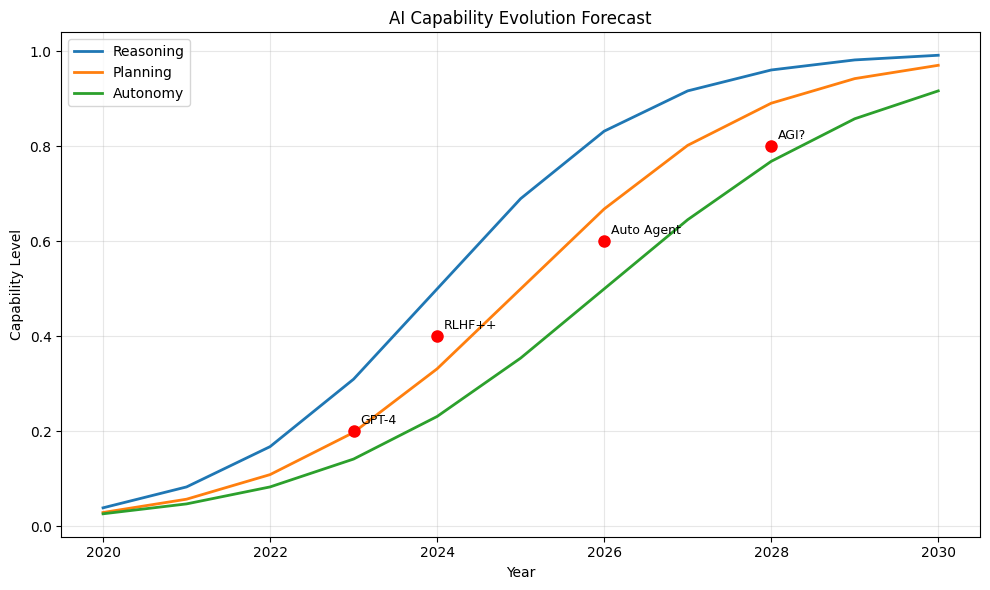

In [8]:
def future_of_rl_llm():
    """
    RL과 LLM의 미래 전망
    """
    
    print("\n" + "="*60)
    print("🚀 RL과 LLM의 미래")
    print("="*60)
    
    future_directions = {
        "1. 자율 에이전트": [
            "• 완전 자율적인 AI 에이전트",
            "• 복잡한 실세계 문제 해결",
            "• 장기 계획과 실행"
        ],
        
        "2. 추론 스케일링": [
            "• Test-time compute 최적화",
            "• 더 깊은 추론 체인",
            "• 자기 반성과 개선"
        ],
        
        "3. 인간-AI 협력": [
            "• RLHF의 고도화",
            "• 실시간 피드백 학습",
            "• 가치 정렬 개선"
        ],
        
        "4. 메타 학습": [
            "• 학습하는 방법을 학습",
            "• Few-shot RL",
            "• 빠른 적응"
        ],
        
        "5. 안전성": [
            "• Constitutional AI 발전",
            "• 해석 가능한 보상 모델",
            "• 안전한 탐색"
        ]
    }
    
    for category, items in future_directions.items():
        print(f"\n{category}")
        for item in items:
            print(f"  {item}")
    
    # 기술 발전 타임라인
    print("\n\n📅 예상 타임라인:")
    
    timeline = [
        ("2024-2025", "RLHF 고도화, 더 나은 보상 모델"),
        ("2025-2026", "자율 에이전트의 실용화"),
        ("2026-2027", "메타 RL + LLM 통합"),
        ("2027-2028", "AGI 수준의 계획과 추론"),
        ("2028+", "완전 자율 AI 시스템")
    ]
    
    for period, milestone in timeline:
        print(f"  {period}: {milestone}")
    
    # 핵심 연구 주제
    print("\n\n🔬 핵심 연구 주제:")
    
    research_topics = [
        "Scalable Oversight: 인간이 검증하기 어려운 작업 감독",
        "Recursive Reward Modeling: 보상 모델이 스스로 개선",
        "Debate와 Amplification: AI 간 토론으로 진실 발견",
        "Interpretability: RL 결정 과정 이해",
        "Robustness: 분포 외 일반화"
    ]
    
    for i, topic in enumerate(research_topics, 1):
        print(f"  {i}. {topic}")
    
    # 시각화: 발전 궤적
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 능력 발전 곡선
    years = np.arange(2020, 2031)
    
    # 각 능력의 발전 궤적
    reasoning = 1 / (1 + np.exp(-(years - 2024) * 0.8))
    planning = 1 / (1 + np.exp(-(years - 2025) * 0.7))
    autonomy = 1 / (1 + np.exp(-(years - 2026) * 0.6))
    
    ax.plot(years, reasoning, label='Reasoning', linewidth=2)
    ax.plot(years, planning, label='Planning', linewidth=2)
    ax.plot(years, autonomy, label='Autonomy', linewidth=2)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Capability Level')
    ax.set_title('AI Capability Evolution Forecast')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 주요 마일스톤 표시
    milestones = [
        (2023, 0.2, 'GPT-4'),
        (2024, 0.4, 'RLHF++'),
        (2026, 0.6, 'Auto Agent'),
        (2028, 0.8, 'AGI?')
    ]
    
    for year, level, label in milestones:
        ax.plot(year, level, 'ro', markersize=8)
        ax.annotate(label, (year, level), xytext=(5, 5), 
                   textcoords='offset points', fontsize=9)
    
    plt.tight_layout()
    plt.show()

future_of_rl_llm()

## 10. 요약 및 결론

### RLHF의 핵심 개념

1. **3단계 프로세스**
   - 선호도 데이터 수집
   - 보상 모델 학습
   - PPO fine-tuning

2. **Constitutional AI**
   - 원칙 기반 자기 개선
   - 자기 비평과 수정
   - 안전한 AI 구축

3. **LLM as Policy**
   - 언어 모델을 직접 정책으로
   - Chain-of-Thought 추론
   - In-context learning

4. **미래 방향**
   - 자율 에이전트
   - 메타 학습
   - 인간-AI 협력

In [9]:
# 최종 정리
print("\n" + "="*60)
print("🎓 전체 RL 여정 정리")
print("="*60)

journey = """
📚 우리가 배운 것:

1. RL 기초 (Notebook 1)
   • MDP와 가치 함수
   • 동적 프로그래밍
   • Bellman 방정식

2. 전통 RL (Notebook 2)
   • Q-Learning
   • SARSA
   • TD 학습

3. Deep RL (Notebook 3)
   • DQN
   • Policy Gradient
   • PPO

4. 추론 기반 RL (Notebook 4)
   • ReAct
   • THINK as Action
   • Test-time compute

5. LLM + RL (Notebook 5)
   • RLHF
   • Constitutional AI
   • LLM as Policy

🔑 핵심 통찰:

• 전반전 → 후반전 패러다임 전환
• 알고리즘 최적화 → 추론 활용
• 많은 데이터 → 효율적 학습
• 단순 보상 → 인간 가치 정렬

🚀 미래:

RL과 LLM의 융합은 AGI로 가는 길
• 자율적 문제 해결
• 인간 수준의 계획
• 가치 정렬된 AI
"""

print(journey)

print("\n" + "="*60)
print("🎉 축하합니다!")
print("강화학습의 기초부터 최첨단 LLM+RL까지 마스터했습니다!")
print("="*60)


🎓 전체 RL 여정 정리

📚 우리가 배운 것:

1. RL 기초 (Notebook 1)
   • MDP와 가치 함수
   • 동적 프로그래밍
   • Bellman 방정식

2. 전통 RL (Notebook 2)
   • Q-Learning
   • SARSA
   • TD 학습

3. Deep RL (Notebook 3)
   • DQN
   • Policy Gradient
   • PPO

4. 추론 기반 RL (Notebook 4)
   • ReAct
   • THINK as Action
   • Test-time compute

5. LLM + RL (Notebook 5)
   • RLHF
   • Constitutional AI
   • LLM as Policy

🔑 핵심 통찰:

• 전반전 → 후반전 패러다임 전환
• 알고리즘 최적화 → 추론 활용
• 많은 데이터 → 효율적 학습
• 단순 보상 → 인간 가치 정렬

🚀 미래:

RL과 LLM의 융합은 AGI로 가는 길
• 자율적 문제 해결
• 인간 수준의 계획
• 가치 정렬된 AI


🎉 축하합니다!
강화학습의 기초부터 최첨단 LLM+RL까지 마스터했습니다!


In [10]:
# 학습 체크포인트
print("\n🎯 최종 학습 체크리스트:")
print("✅ RLHF 3단계 프로세스 이해")
print("✅ 보상 모델 학습 구현")
print("✅ PPO fine-tuning 이해")
print("✅ Constitutional AI 개념")
print("✅ LLM을 정책으로 사용")
print("✅ 멀티 에이전트 시스템")
print("✅ RL+LLM 미래 전망")
print("\n🏆 완벽합니다! RL과 LLM의 최전선에 도달했습니다!")


🎯 최종 학습 체크리스트:
✅ RLHF 3단계 프로세스 이해
✅ 보상 모델 학습 구현
✅ PPO fine-tuning 이해
✅ Constitutional AI 개념
✅ LLM을 정책으로 사용
✅ 멀티 에이전트 시스템
✅ RL+LLM 미래 전망

🏆 완벽합니다! RL과 LLM의 최전선에 도달했습니다!
